In [1]:
import itertools
import time
import os
import glob
import sys
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import least_squares

### Lambda and Sigma parameters of the HPS model

In [2]:
jsondata = '{"codes":{"ARG":"R","ASP":"D","ASN":"N","GLU":"E","LYS":"K","HIS":"H","GLN":"Q","SER":"S","CYS":"C","GLY":"G","THR":"T","ALA":"A","MET":"M","TYR":"Y","VAL":"V","TRP":"W","LEU":"L","ILE":"I","PRO":"P","PHE":"F"},"MW":{"ARG":156.19,"ASP":115.09,"ASN":114.1,"GLU":129.11,"LYS":128.17,"HIS":137.14,"GLN":128.13,"SER":87.08,"CYS":103.14,"GLY":57.05,"THR":101.11,"ALA":71.07,"MET":131.2,"TYR":163.18,"VAL":99.13,"TRP":186.22,"LEU":113.16,"ILE":113.16,"PRO":97.12,"PHE":147.18},"sigmas":{"ARG":0.656,"ASP":0.558,"ASN":0.568,"GLU":0.592,"LYS":0.636,"HIS":0.608,"GLN":0.602,"SER":0.518,"CYS":0.548,"GLY":0.45,"THR":0.562,"ALA":0.504,"MET":0.618,"TYR":0.646,"VAL":0.586,"TRP":0.678,"LEU":0.618,"ILE":0.618,"PRO":0.556,"PHE":0.636},"lambdas":{"ARG":0.0,"ASP":0.378378,"ASN":0.432432,"GLU":0.459459,"LYS":0.513514,"HIS":0.513514,"GLN":0.513514,"SER":0.594595,"CYS":0.594595,"GLY":0.648649,"THR":0.675676,"ALA":0.72973,"MET":0.837838,"TYR":0.864865,"VAL":0.891892,"TRP":0.945946,"LEU":0.972973,"ILE":0.972973,"PRO":1.0,"PHE":1.0},"q":{"ARG":1,"ASP":-1,"ASN":0,"GLU":-1,"LYS":1,"HIS":0,"GLN":0,"SER":0,"CYS":0,"GLY":0,"THR":0,"ALA":0,"MET":0,"TYR":0,"VAL":0,"TRP":0,"LEU":0,"ILE":0,"PRO":0,"PHE":0}}'

In [3]:
df = pd.read_json(jsondata)
sigmamap = pd.DataFrame((df.sigmas.values+df.sigmas.values.reshape(-1,1))/2,index=df.sigmas.index,columns=df.sigmas.index)
lambdamap = pd.DataFrame((df.lambdas.values+df.lambdas.values.reshape(-1,1))/2,index=df.lambdas.index,columns=df.lambdas.index)

In [6]:
sigmamap

,ARG,ASP,ASN,GLU,LYS,HIS,GLN,SER,CYS,GLY,THR,ALA,MET,TYR,VAL,TRP,LEU,ILE,PRO,PHE
ARG,0.656,0.607,0.612,0.624,0.646,0.632,0.629,0.587,0.602,0.553,0.609,0.580,0.637,0.651,0.621,0.667,0.637,0.637,0.606,0.646
ASP,0.607,0.558,0.563,0.575,0.597,0.583,0.580,0.538,0.553,0.504,0.560,0.531,0.588,0.602,0.572,0.618,0.588,0.588,0.557,0.597
ASN,0.612,0.563,0.568,0.580,0.602,0.588,0.585,0.543,0.558,0.509,0.565,0.536,0.593,0.607,0.577,0.623,0.593,0.593,0.562,0.602
GLU,0.624,0.575,0.580,0.592,0.614,0.600,0.597,0.555,0.570,0.521,0.577,0.548,0.605,0.619,0.589,0.635,0.605,0.605,0.574,0.614
LYS,0.646,0.597,0.602,0.614,0.636,0.622,0.619,0.577,0.592,0.543,0.599,0.570,0.627,0.641,0.611,0.657,0.627,0.627,0.596,0.636
HIS,0.632,0.583,0.588,0.600,0.622,0.608,0.605,0.563,0.578,0.529,0.585,0.556,0.613,0.627,0.597,0.643,0.613,0.613,0.582,0.622
GLN,0.629,0.580,0.585,0.597,0.619,0.605,0.602,0.560,0.575,0.526,0.582,0.553,0.610,0.624,0.594,0.640,0.610,0.610,0.579,0.619
SER,0.587,0.538,0.543,0.555,0.577,0.563,0.560,0.518,0.533,0.484,0.540,0.511,0.568,0.582,0.552,0.598,0.568,0.568,0.537,0.577
CYS,0.602,0.553,0.558,0.570,0.592,0.578,0.575,0.533,0.548,0.499,0.555,0.526,0.583,0.597,0.567,0.613,0.583,0.583,0.552,0.592
GLY,0.553,0.504,0.509,0.521,0.543,0.529,0.526,0.484,0.499,0.450,0.506,0.477,0.534,0.548,0.518,0.564,0.534,0.534,0.503,0.543


In [7]:
s_scale = 0.95

def hps(s,l):
    # piece-wise HPS potential
    print(s)
    x = np.linspace(s,2,1000)
    eps = .2*4.184
    f1 = lambda x : 4*eps*(-(s/x)**6+(s/x)**12)*l
    f2 = lambda x : 4*eps*(-(s/x)**6+(s/x)**12)+(1-l)*eps
    mask = x>2**(1/6)*s
    return np.append( f2(x[~mask]) , f1(x[mask]))

def customLJ_GMX(s,l,p1,p2):
    # GMX LJ potential
    x = np.linspace(s,2,1000)
    eps = .2*4.184
    x6 = (s/x)**6
    return 4*eps*(-p1*x6+p2*x6**2)

def residuals_GMX(p, *args):
    s, l = args
    r = customLJ_GMX(s,l,p[0],p[1]) - hps(s,l)
    return r

0.656
0.656
0.656
0.656
0.656
0.656
0.656
0.656
0.656
0.607
0.607
0.607
0.607
0.607
0.607
0.607
0.607
0.607
0.6120000000000001
0.6120000000000001
0.6120000000000001
0.6120000000000001
0.6120000000000001
0.6120000000000001
0.6120000000000001
0.6120000000000001
0.6120000000000001
0.624
0.624
0.624
0.624
0.624
0.624
0.624
0.624
0.624
0.646
0.646
0.646
0.646
0.646
0.646
0.646
0.646
0.646
0.632
0.632
0.632
0.632
0.632
0.632
0.632
0.629
0.629
0.629
0.629
0.629
0.629
0.629
0.587
0.587
0.587
0.587
0.587
0.587
0.587
0.587
0.587
0.6020000000000001
0.6020000000000001
0.6020000000000001
0.6020000000000001
0.6020000000000001
0.6020000000000001
0.6020000000000001
0.553
0.553
0.553
0.553
0.553
0.553
0.553
0.553
0.553
0.609
0.609
0.609
0.609
0.609
0.609
0.609
0.609
0.609
0.5800000000000001
0.5800000000000001
0.5800000000000001
0.5800000000000001
0.5800000000000001
0.5800000000000001
0.5800000000000001
0.5800000000000001
0.5800000000000001
0.637
0.637
0.637
0.637
0.637
0.637
0.637
0.637
0.637
0.651
0.6

0.61
0.579
0.579
0.579
0.579
0.579
0.579
0.579
0.619
0.619
0.619
0.619
0.619
0.619
0.518
0.518
0.518
0.518
0.518
0.518
0.518
0.533
0.533
0.533
0.533
0.533
0.533
0.533
0.533
0.533
0.484
0.484
0.484
0.484
0.484
0.484
0.484
0.54
0.54
0.54
0.54
0.54
0.54
0.54
0.511
0.511
0.511
0.511
0.511
0.511
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5820000000000001
0.5820000000000001
0.5820000000000001
0.5820000000000001
0.5820000000000001
0.5820000000000001
0.5820000000000001
0.552
0.552
0.552
0.552
0.552
0.552
0.552
0.552
0.552
0.5980000000000001
0.5980000000000001
0.5980000000000001
0.5980000000000001
0.5980000000000001
0.5980000000000001
0.5980000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.5680000000000001
0.568000

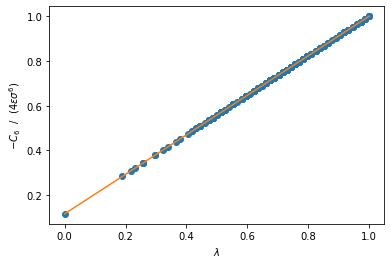

In [8]:
param6 = np.empty(0)
lambdas = np.empty(0)
eps = .2*4.184
for a,b in np.array(list(itertools.combinations_with_replacement(df.index,2))):
    s, l = sigmamap.loc[a,b], lambdamap.loc[a,b]
    res = least_squares(residuals_GMX, x0=[.9,.7], args=[s,l])
    param6 = np.append(param6,res.x[0])
    lambdas = np.append(lambdas,l)
plt.plot(lambdas,param6,lw=0,marker='o')
z1 = np.polyfit(lambdas, param6, 1)
print(z1)
plt.plot(lambdas,z1[0]*lambdas+z1[1])
plt.ylabel(r'$-C_6$  /  $(4\epsilon \sigma^6)$')
plt.xlabel(r'$\lambda$')
plt.show()

\begin{equation}
C_6 = - 4 \epsilon \sigma^6 (0.76\lambda+0.24)
\end{equation}

\begin{equation}
C_{12} = 4 \epsilon \sigma^{12} (0.48\lambda+0.52)
\end{equation}